In [1]:
import numpy as np
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
from torch.utils import data

import catalyst
from catalyst import dl
from catalyst.utils import metrics, imread, set_global_seed

import cv2
import matplotlib.pyplot as plt

In [2]:
def show_image(image, figsize=(20, 20), title=None, cmap=None, axis=False):
    """
    show single image
    
    :param image: np.array: image
    :param figsize: (int, int): figure size
    :param title: str: image title
    :param cmap: str: colormap name, for example "Greys_r"
    :param axis: bool: draw axis or not
    :return: None
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    if not axis:
        plt.axis('off')
    plt.imshow(image, cmap)
    plt.show()

In [3]:
def subplot_images(images, n_rows, n_columns, figsize=(20, 20), titles=None, cmap=None, axis=False, layout_pad=(1, 1)):
    """
    show several images
    :param images: list(np.array): list of images
    :param n_rows: int: row number
    :param n_columns: int: column number
    :param figsize: (int, int): figure size
    :param titles: str or list[str]: image titles
    :param cmap: str: colormap name, for example "Greys_r"
    :param axis: bool: draw axis or not
    :param layout_pad: (float, float): padding (width/height) between subplots
    :return: None
    """
    assert len(images) <= n_rows * n_columns
    if titles is None or type(titles) == str:
        titles = [titles] * len(images)
    plt.figure(figsize=figsize)
    for i, image in enumerate(images, start=1):
        plt.subplot(n_rows, n_columns, i, ymargin=0.5, xmargin=0.5)
        plt.title(titles[i-1])
        if not axis:
            plt.axis('off')
        plt.tight_layout(w_pad=layout_pad[0], h_pad=layout_pad[1])
        plt.imshow(image, cmap)
    plt.show()

In [4]:
train_image_path = Path("./../dataset/train") / "images"
train_mask_path = Path("./../dataset/train") / "masks"
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

In [5]:
from tqdm.notebook import tqdm
for idx, (image_path, mask_path) in enumerate(tqdm(zip(ALL_IMAGES, ALL_MASKS))):
    image_shape = cv2.imread(str(image_path)).shape[:-1]
    mask_shape = cv2.imread(str(mask_path), 2).shape
    assert image_shape == mask_shape

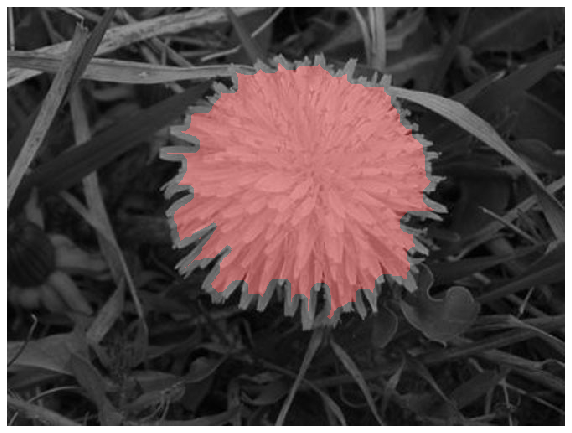

In [6]:
from skimage.color import label2rgb

idx = 300
image = cv2.imread(str(ALL_IMAGES[idx]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(str(ALL_MASKS[idx]), 2)
show_image(label2rgb(mask, image, bg_label=0), (10, 10))

In [5]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor
import cv2

IMAGE_SIZE = 480

In [6]:
import albumentations as albu

import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor
import cv2


def pre_transforms(image_size=480):
    return albu.Compose([
        albu.LongestMaxSize(image_size, cv2.INTER_LANCZOS4),
        albu.PadIfNeeded(image_size, image_size, border_mode=cv2.BORDER_CONSTANT)
    ])

def crop_transforms(size=480):
    result = albu.OneOf([albu.Compose(transforms=[albu.RandomCrop(int(size/1.5), int(size/1.5), p=0.2),
                                       pre_transforms()]), 
           albu.Compose(transforms=[albu.RandomCrop(int(size/2), size//2, p=0.2),
                                       pre_transforms()]),
           albu.Compose(transforms=[albu.RandomCrop(int(size/1.5), int(size/2), p=0.2),
                                       pre_transforms()]),
           albu.Compose(transforms=[albu.RandomCrop(int(size/2), int(size/1.5), p=0.2),
                                       pre_transforms()]),
          ], p=0.2)
    return result


def blur_transforms():
    result = [albu.Blur(p=0.1, blur_limit=5),
              albu.MedianBlur(p=0.1, blur_limit=3),
              albu.GaussianBlur(p=0.1, blur_limit=5),
              albu.MotionBlur(p=0.1, blur_limit=5),
              albu.Downscale(p=0.1, scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_LANCZOS4)]
    return result


def noise_transforms():
    result = [albu.GaussNoise(p=0.1, var_limit=(20, 80)),
              albu.JpegCompression(p=0.1, quality_lower=95),
              albu.IAAAdditiveGaussianNoise(p=0.05)]
    return result


def special_transforms():
    result = [
              albu.CLAHE(clip_limit=2, p=0.1),
              albu.IAASharpen(p=0.1),
              albu.IAAEmboss(p=0.1)
              ]
    return result


def rotate_transforms():
    result = [albu.Rotate(15, p=0.3),
              albu.ShiftScaleRotate(shift_limit=0.1025, scale_limit=0.1, rotate_limit=15, p=0.1)]
    return result

def flip_transforms():
    result = [albu.HorizontalFlip(p=0.25),
              albu.VerticalFlip(p=0.1)]
    return result


def distortiot_transforms():
    result = [albu.GridDistortion(p=0.1),
              albu.IAAPiecewiseAffine(p=0.05),
              albu.OpticalDistortion(p=0.05, distort_limit=0.3, shift_limit=0.5),
              ]
    return result


def color_transforms():
    result = [albu.RandomBrightness(p=0.1),
              albu.RandomContrast(p=0.1),
              albu.RandomGamma(p=0.1),
              albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
              ]
    return result


def post_transforms():
    return [albu.Normalize(), ToTensor()]


def compose(transforms_to_compose):
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result


hard_transforms = compose([blur_transforms(),
                           crop_transforms(),
                           flip_transforms(),
                           noise_transforms(),
                           special_transforms(),
                           rotate_transforms(),
                           distortiot_transforms(),
                           color_transforms()])

train_transforms = compose([
    pre_transforms(),
    hard_transforms,
    post_transforms(),
])

valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms])

In [7]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, images=None, masks=None, transforms=None) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = cv2.imread(str(image_path))

        result = {"image": image}

        if self.masks is not None:
            mask = cv2.imread(str(self.masks[idx]), 2)
            mask = (mask > 0).astype(float)
            result['mask'] = mask
#             result["mask"] = imread(self.masks[idx]).mean(2) // 255

        if self.transforms is not None:
            result = self.transforms(**result)
            if result.get("mask", None) is not None:
                if isinstance(result["mask"], torch.Tensor):
#                     print(1)
                    result["mask"] = result["mask"].unsqueeze(0)

        result["filename"] = image_path.name
        result["image size"] = image.shape[:2]
#         print('image shape', result['image'].shape)
#         print('mask shape', result['mask'].shape)
#         assert result['mask'].shape == (1, 480, 480)
        return result

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

batch_size = 4
num_workers = 0

indices = np.arange(len(ALL_IMAGES))

train_indices, valid_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)

np_images = np.array(ALL_IMAGES)
np_masks = np.array(ALL_MASKS)

train_dataset = SegmentationDataset(
    images = np_images[train_indices].tolist(),
    masks = np_masks[train_indices].tolist(),
    transforms = train_transforms
)

valid_dataset = SegmentationDataset(
    images = np_images[valid_indices].tolist(),
    masks = np_masks[valid_indices].tolist(),
    transforms = valid_transforms
)

loaders = {
    "train": DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    ),
    "valid": DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    )
}

In [10]:
show_dataset = SegmentationDataset(images = np_images[train_indices].tolist(),
                                   masks = np_masks[train_indices].tolist(),
                                   transforms=show_transforms)

In [12]:
images = []
for _ in range(9):
    sample = show_dataset[0]
    images.append(label2rgb(sample['mask'], sample['image'], bg_label=0))

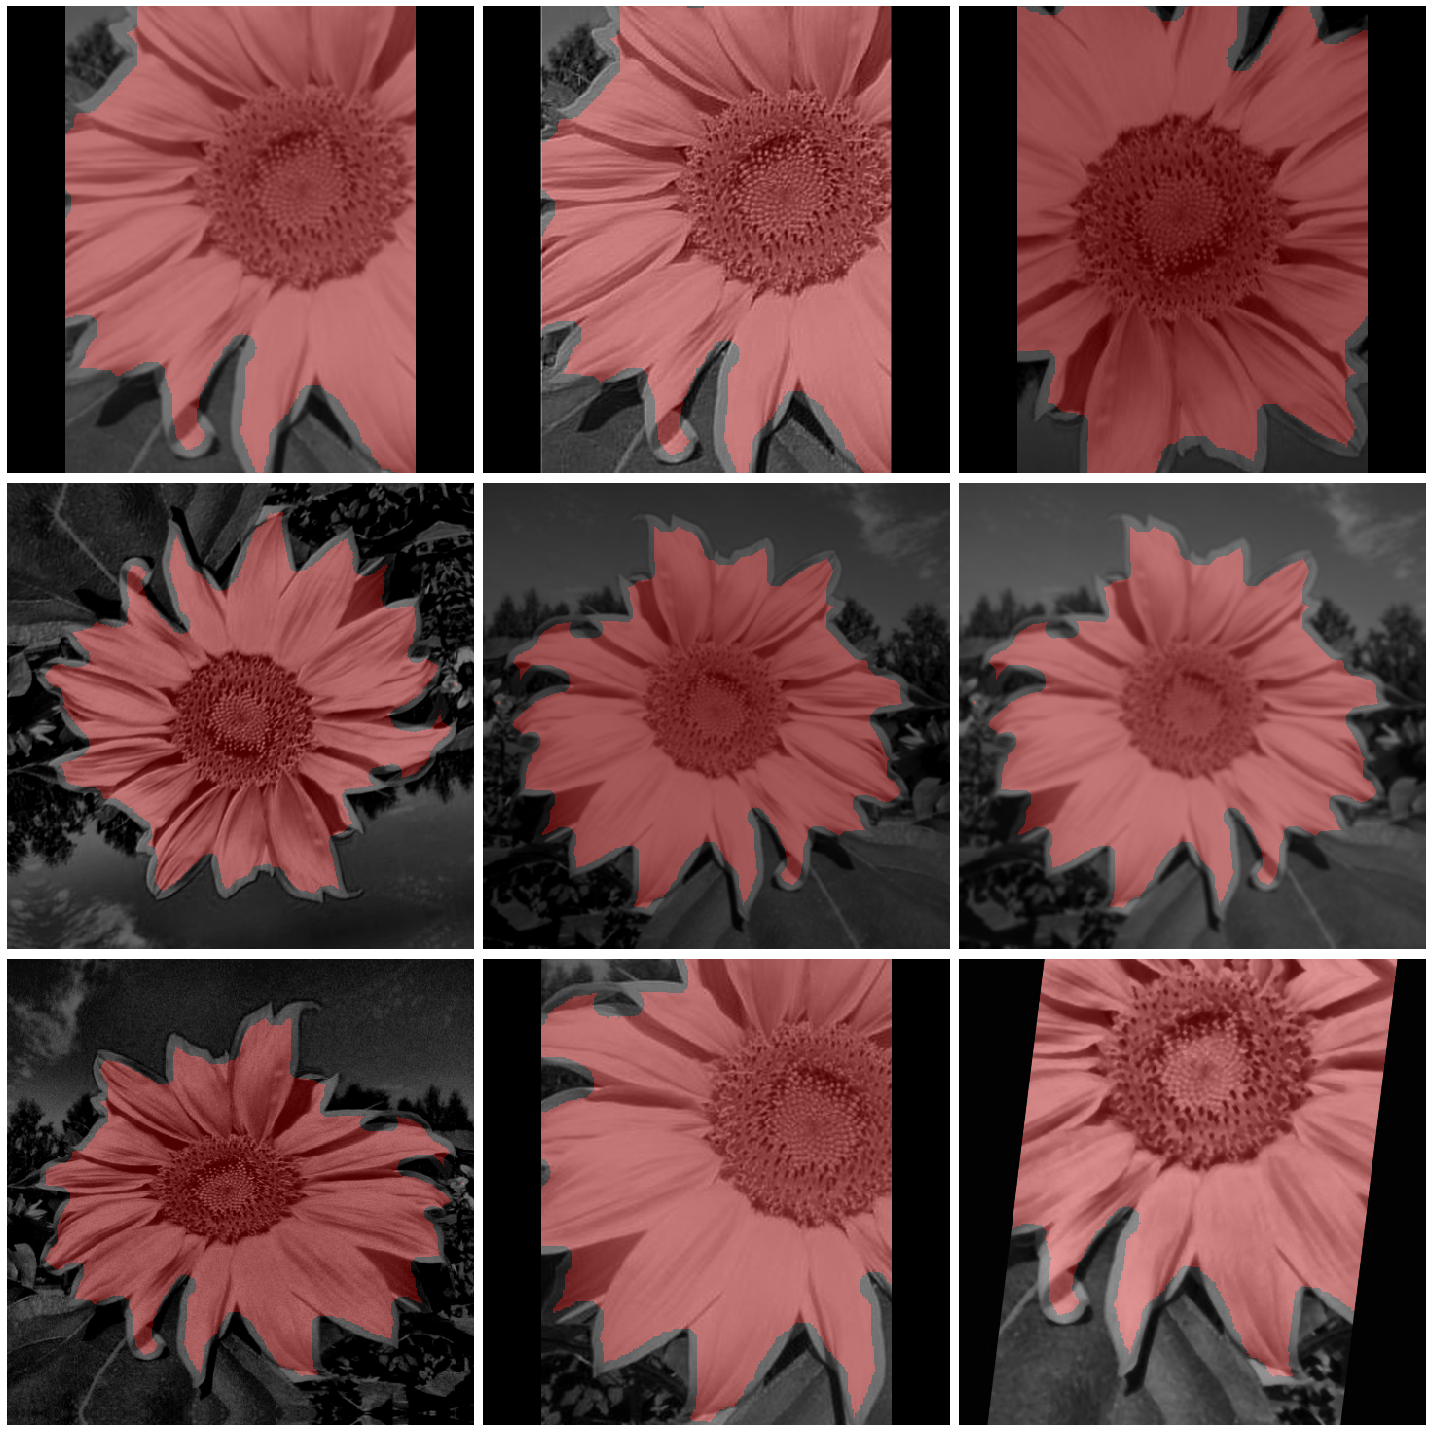

In [13]:
subplot_images(images, 3, 3)

In [9]:
import segmentation_models_pytorch as smp

In [10]:
model = smp.FPN('efficientnet-b6', encoder_weights='imagenet')

In [11]:
batch = next(iter(loaders['train']))

In [34]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.contrib.nn.criterion.focal import FocalLossMultiClass, FocalLossBinary

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [35]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = catalyst.utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=3, mode='max')

In [36]:
from catalyst.dl import SupervisedRunner

num_epochs = 50
logdir = "./../logs/forth_experiment/"

device = torch.device('cuda:0')
print(f"device: {device}")

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda:0


In [37]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, OptimizerCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),


    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),
    OptimizerCallback('loss', accumulation_steps=4),
    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)



1/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]

1/50 * Epoch (train):   0% 0/81 [00:09<?, ?it/s, dice=0.920, iou=0.851, loss=0.331, loss_bce=0.126, loss_dice=0.080, loss_iou=0.149]

1/50 * Epoch (train):   1% 1/81 [00:09<12:43,  9.55s/it, dice=0.920, iou=0.851, loss=0.331, loss_bce=0.126, loss_dice=0.080, loss_iou=0.149]

1/50 * Epoch (train):   1% 1/81 [00:13<12:43,  9.55s/it, dice=0.950, iou=0.905, loss=0.180, loss_bce=0.043, loss_dice=0.050, loss_iou=0.095]

1/50 * Epoch (train):   2% 2/81 [00:13<10:22,  7.88s/it, dice=0.950, iou=0.905, loss=0.180, loss_bce=0.043, loss_dice=0.050, loss_iou=0.095]

1/50 * Epoch (train):   2% 2/81 [00:13<10:22,  7.88s/it, dice=0.961, iou=0.925, loss=0.157, loss_bce=0.054, loss_dice=0.039, loss_iou=0.075]

1/50 * Epoch (train):   4% 3/81 [00:13<07:20,  5.65s/it, dice=0.961, iou=0.925, loss=0.157, loss_bce=0.054, loss_dice=0.039, loss_iou=0.075]

1/50 * Epoch (train):   4% 3/81 [00:14<07:20,  5.65s/it, dice=0.953, iou=0.910, loss=0.208, loss_bce=0.0

1/50 * Epoch (train):  67% 54/81 [00:45<00:14,  1.91it/s, dice=0.954, iou=0.913, loss=0.165, loss_bce=0.040, loss_dice=0.046, loss_iou=0.087]

1/50 * Epoch (train):  68% 55/81 [00:45<00:13,  1.97it/s, dice=0.954, iou=0.913, loss=0.165, loss_bce=0.040, loss_dice=0.046, loss_iou=0.087]

1/50 * Epoch (train):  68% 55/81 [00:46<00:13,  1.97it/s, dice=0.970, iou=0.943, loss=0.131, loss_bce=0.054, loss_dice=0.030, loss_iou=0.057]

1/50 * Epoch (train):  69% 56/81 [00:46<00:15,  1.62it/s, dice=0.970, iou=0.943, loss=0.131, loss_bce=0.054, loss_dice=0.030, loss_iou=0.057]

1/50 * Epoch (train):  69% 56/81 [00:46<00:15,  1.62it/s, dice=0.965, iou=0.933, loss=0.148, loss_bce=0.058, loss_dice=0.035, loss_iou=0.067]

1/50 * Epoch (train):  70% 57/81 [00:46<00:13,  1.72it/s, dice=0.965, iou=0.933, loss=0.148, loss_bce=0.058, loss_dice=0.035, loss_iou=0.067]

1/50 * Epoch (train):  70% 57/81 [00:47<00:13,  1.72it/s, dice=0.938, iou=0.884, loss=0.230, loss_bce=0.065, loss_dice=0.062, loss_iou=0.116]


I1014 21:21:42.957036 140000092989184 logging.py:164] 
1/50 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/50 * Epoch 1 (train): dice=0.9562 | iou=0.9168 | loss=0.1839 | loss_bce=0.0711 | loss_dice=0.0438 | loss_iou=0.0832
1/50 * Epoch 1 (valid): dice=0.9443 | iou=0.8952 | loss=0.2058 | loss_bce=0.0567 | loss_dice=0.0557 | loss_iou=0.1048




2/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]

2/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.967, iou=0.937, loss=0.160, loss_bce=0.080, loss_dice=0.033, loss_iou=0.063]

2/50 * Epoch (train):   1% 1/81 [00:00<00:43,  1.82it/s, dice=0.967, iou=0.937, loss=0.160, loss_bce=0.080, loss_dice=0.033, loss_iou=0.063]

2/50 * Epoch (train):   1% 1/81 [00:01<00:43,  1.82it/s, dice=0.970, iou=0.943, loss=0.124, loss_bce=0.046, loss_dice=0.030, loss_iou=0.057]

2/50 * Epoch (train):   2% 2/81 [00:01<00:41,  1.91it/s, dice=0.970, iou=0.943, loss=0.124, loss_bce=0.046, loss_dice=0.030, loss_iou=0.057]

2/50 * Epoch (train):   2% 2/81 [00:01<00:41,  1.91it/s, dice=0.951, iou=0.907, loss=0.198, loss_bce=0.070, loss_dice=0.049, loss_iou=0.093]

2/50 * Epoch (train):   4% 3/81 [00:01<00:43,  1.78it/s, dice=0.951, iou=0.907, loss=0.198, loss_bce=0.070, loss_dice=0.049, loss_iou=0.093]

2/50 * Epoch (train):   4% 3/81 [00:02<00:43,  1.78it/s, dice=0.955, iou=0.914, loss=0.180, loss_bce=0.0

2/50 * Epoch (train):  67% 54/81 [00:33<00:16,  1.62it/s, dice=0.945, iou=0.897, loss=0.185, loss_bce=0.034, loss_dice=0.055, loss_iou=0.103]

2/50 * Epoch (train):  68% 55/81 [00:33<00:17,  1.51it/s, dice=0.945, iou=0.897, loss=0.185, loss_bce=0.034, loss_dice=0.055, loss_iou=0.103]

2/50 * Epoch (train):  68% 55/81 [00:34<00:17,  1.51it/s, dice=0.936, iou=0.879, loss=0.245, loss_bce=0.075, loss_dice=0.064, loss_iou=0.121]

2/50 * Epoch (train):  69% 56/81 [00:34<00:15,  1.63it/s, dice=0.936, iou=0.879, loss=0.245, loss_bce=0.075, loss_dice=0.064, loss_iou=0.121]

2/50 * Epoch (train):  69% 56/81 [00:34<00:15,  1.63it/s, dice=0.962, iou=0.927, loss=0.188, loss_bce=0.097, loss_dice=0.038, loss_iou=0.073]

2/50 * Epoch (train):  70% 57/81 [00:34<00:14,  1.67it/s, dice=0.962, iou=0.927, loss=0.188, loss_bce=0.097, loss_dice=0.038, loss_iou=0.073]

2/50 * Epoch (train):  70% 57/81 [00:35<00:14,  1.67it/s, dice=0.965, iou=0.932, loss=0.154, loss_bce=0.064, loss_dice=0.035, loss_iou=0.068]


I1014 21:22:44.194955 140000092989184 logging.py:164] 
2/50 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/50 * Epoch 2 (train): dice=0.9562 | iou=0.9170 | loss=0.1855 | loss_bce=0.0734 | loss_dice=0.0438 | loss_iou=0.0830
2/50 * Epoch 2 (valid): dice=0.9439 | iou=0.8945 | loss=0.2061 | loss_bce=0.0557 | loss_dice=0.0561 | loss_iou=0.1055




3/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]

3/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.964, iou=0.930, loss=0.157, loss_bce=0.064, loss_dice=0.036, loss_iou=0.070]

3/50 * Epoch (train):   1% 1/81 [00:00<00:52,  1.53it/s, dice=0.964, iou=0.930, loss=0.157, loss_bce=0.064, loss_dice=0.036, loss_iou=0.070]

3/50 * Epoch (train):   1% 1/81 [00:01<00:52,  1.53it/s, dice=0.969, iou=0.940, loss=0.141, loss_bce=0.063, loss_dice=0.031, loss_iou=0.060]

3/50 * Epoch (train):   2% 2/81 [00:01<00:53,  1.47it/s, dice=0.969, iou=0.940, loss=0.141, loss_bce=0.063, loss_dice=0.031, loss_iou=0.060]

3/50 * Epoch (train):   2% 2/81 [00:01<00:53,  1.47it/s, dice=0.965, iou=0.933, loss=0.144, loss_bce=0.053, loss_dice=0.035, loss_iou=0.067]

3/50 * Epoch (train):   4% 3/81 [00:01<00:49,  1.57it/s, dice=0.965, iou=0.933, loss=0.144, loss_bce=0.053, loss_dice=0.035, loss_iou=0.067]

3/50 * Epoch (train):   4% 3/81 [00:02<00:49,  1.57it/s, dice=0.977, iou=0.955, loss=0.108, loss_bce=0.0

3/50 * Epoch (train):  67% 54/81 [00:48<00:16,  1.63it/s, dice=0.968, iou=0.937, loss=0.137, loss_bce=0.052, loss_dice=0.032, loss_iou=0.063]

3/50 * Epoch (train):  68% 55/81 [00:48<00:16,  1.57it/s, dice=0.968, iou=0.937, loss=0.137, loss_bce=0.052, loss_dice=0.032, loss_iou=0.063]

3/50 * Epoch (train):  68% 55/81 [00:48<00:16,  1.57it/s, dice=0.954, iou=0.912, loss=0.182, loss_bce=0.061, loss_dice=0.046, loss_iou=0.088]

3/50 * Epoch (train):  69% 56/81 [00:48<00:14,  1.71it/s, dice=0.954, iou=0.912, loss=0.182, loss_bce=0.061, loss_dice=0.046, loss_iou=0.088]

3/50 * Epoch (train):  69% 56/81 [00:49<00:14,  1.71it/s, dice=0.978, iou=0.956, loss=0.107, loss_bce=0.050, loss_dice=0.022, loss_iou=0.044]

3/50 * Epoch (train):  70% 57/81 [00:49<00:14,  1.71it/s, dice=0.978, iou=0.956, loss=0.107, loss_bce=0.050, loss_dice=0.022, loss_iou=0.044]

3/50 * Epoch (train):  70% 57/81 [00:49<00:14,  1.71it/s, dice=0.930, iou=0.869, loss=0.269, loss_bce=0.086, loss_dice=0.070, loss_iou=0.131]


I1014 21:23:59.104283 140000092989184 logging.py:164] 
3/50 * Epoch 3 (_base): lr=0.0005 | momentum=0.9000
3/50 * Epoch 3 (train): dice=0.9593 | iou=0.9224 | loss=0.1737 | loss_bce=0.0694 | loss_dice=0.0407 | loss_iou=0.0776
3/50 * Epoch 3 (valid): dice=0.9435 | iou=0.8938 | loss=0.2085 | loss_bce=0.0572 | loss_dice=0.0565 | loss_iou=0.1062




4/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]

4/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.966, iou=0.934, loss=0.179, loss_bce=0.098, loss_dice=0.034, loss_iou=0.066]

4/50 * Epoch (train):   1% 1/81 [00:00<00:54,  1.47it/s, dice=0.966, iou=0.934, loss=0.179, loss_bce=0.098, loss_dice=0.034, loss_iou=0.066]

4/50 * Epoch (train):   1% 1/81 [00:01<00:54,  1.47it/s, dice=0.942, iou=0.891, loss=0.231, loss_bce=0.081, loss_dice=0.058, loss_iou=0.109]

4/50 * Epoch (train):   2% 2/81 [00:01<00:50,  1.55it/s, dice=0.942, iou=0.891, loss=0.231, loss_bce=0.081, loss_dice=0.058, loss_iou=0.109]

4/50 * Epoch (train):   2% 2/81 [00:01<00:50,  1.55it/s, dice=0.952, iou=0.908, loss=0.171, loss_bce=0.039, loss_dice=0.048, loss_iou=0.092]

4/50 * Epoch (train):   4% 3/81 [00:01<00:46,  1.68it/s, dice=0.952, iou=0.908, loss=0.171, loss_bce=0.039, loss_dice=0.048, loss_iou=0.092]

4/50 * Epoch (train):   4% 3/81 [00:02<00:46,  1.68it/s, dice=0.960, iou=0.923, loss=0.175, loss_bce=0.0

4/50 * Epoch (train):  67% 54/81 [00:39<00:22,  1.19it/s, dice=0.971, iou=0.944, loss=0.120, loss_bce=0.043, loss_dice=0.029, loss_iou=0.056]

4/50 * Epoch (train):  68% 55/81 [00:39<00:19,  1.33it/s, dice=0.971, iou=0.944, loss=0.120, loss_bce=0.043, loss_dice=0.029, loss_iou=0.056]

4/50 * Epoch (train):  68% 55/81 [00:40<00:19,  1.33it/s, dice=0.962, iou=0.926, loss=0.158, loss_bce=0.058, loss_dice=0.038, loss_iou=0.074]

4/50 * Epoch (train):  69% 56/81 [00:40<00:17,  1.43it/s, dice=0.962, iou=0.926, loss=0.158, loss_bce=0.058, loss_dice=0.038, loss_iou=0.074]

4/50 * Epoch (train):  69% 56/81 [00:41<00:17,  1.43it/s, dice=0.974, iou=0.949, loss=0.116, loss_bce=0.048, loss_dice=0.026, loss_iou=0.051]

4/50 * Epoch (train):  70% 57/81 [00:41<00:17,  1.35it/s, dice=0.974, iou=0.949, loss=0.116, loss_bce=0.048, loss_dice=0.026, loss_iou=0.051]

4/50 * Epoch (train):  70% 57/81 [00:41<00:17,  1.35it/s, dice=0.944, iou=0.894, loss=0.266, loss_bce=0.129, loss_dice=0.056, loss_iou=0.106]


I1014 21:25:05.599308 140000092989184 logging.py:164] 
4/50 * Epoch 4 (_base): lr=0.0005 | momentum=0.9000
4/50 * Epoch 4 (train): dice=0.9606 | iou=0.9245 | loss=0.1671 | loss_bce=0.0652 | loss_dice=0.0394 | loss_iou=0.0755
4/50 * Epoch 4 (valid): dice=0.9449 | iou=0.8962 | loss=0.2037 | loss_bce=0.0560 | loss_dice=0.0551 | loss_iou=0.1038




5/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]

5/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.950, iou=0.904, loss=0.186, loss_bce=0.049, loss_dice=0.050, loss_iou=0.096]

5/50 * Epoch (train):   1% 1/81 [00:00<00:41,  1.92it/s, dice=0.950, iou=0.904, loss=0.186, loss_bce=0.049, loss_dice=0.050, loss_iou=0.096]

5/50 * Epoch (train):   1% 1/81 [00:01<00:41,  1.92it/s, dice=0.967, iou=0.936, loss=0.126, loss_bce=0.036, loss_dice=0.033, loss_iou=0.064]

5/50 * Epoch (train):   2% 2/81 [00:01<00:41,  1.92it/s, dice=0.967, iou=0.936, loss=0.126, loss_bce=0.036, loss_dice=0.033, loss_iou=0.064]

5/50 * Epoch (train):   2% 2/81 [00:06<00:41,  1.92it/s, dice=0.972, iou=0.946, loss=0.113, loss_bce=0.038, loss_dice=0.028, loss_iou=0.054]

5/50 * Epoch (train):   4% 3/81 [00:06<02:34,  1.98s/it, dice=0.972, iou=0.946, loss=0.113, loss_bce=0.038, loss_dice=0.028, loss_iou=0.054]

5/50 * Epoch (train):   4% 3/81 [00:07<02:34,  1.98s/it, dice=0.968, iou=0.938, loss=0.134, loss_bce=0.0

7/50 * Epoch (train):  46% 37/81 [00:22<00:25,  1.74it/s, dice=0.962, iou=0.927, loss=0.182, loss_bce=0.089, loss_dice=0.038, loss_iou=0.073]

7/50 * Epoch (train):  47% 38/81 [00:22<00:25,  1.66it/s, dice=0.962, iou=0.927, loss=0.182, loss_bce=0.089, loss_dice=0.038, loss_iou=0.073]

7/50 * Epoch (train):  47% 38/81 [00:22<00:25,  1.66it/s, dice=0.968, iou=0.938, loss=0.132, loss_bce=0.047, loss_dice=0.032, loss_iou=0.062]

7/50 * Epoch (train):  48% 39/81 [00:22<00:24,  1.73it/s, dice=0.968, iou=0.938, loss=0.132, loss_bce=0.047, loss_dice=0.032, loss_iou=0.062]

7/50 * Epoch (train):  48% 39/81 [00:23<00:24,  1.73it/s, dice=0.960, iou=0.923, loss=0.173, loss_bce=0.069, loss_dice=0.040, loss_iou=0.077]

7/50 * Epoch (train):  49% 40/81 [00:23<00:23,  1.77it/s, dice=0.960, iou=0.923, loss=0.173, loss_bce=0.069, loss_dice=0.040, loss_iou=0.077]

7/50 * Epoch (train):  49% 40/81 [00:23<00:23,  1.77it/s, dice=0.961, iou=0.925, loss=0.146, loss_bce=0.040, loss_dice=0.039, loss_iou=0.075]


7/50 * Epoch (valid):  50% 10/20 [00:02<00:02,  3.52it/s, dice=0.960, iou=0.922, loss=0.166, loss_bce=0.060, loss_dice=0.040, loss_iou=0.078]

7/50 * Epoch (valid):  50% 10/20 [00:03<00:02,  3.52it/s, dice=0.955, iou=0.914, loss=0.160, loss_bce=0.037, loss_dice=0.045, loss_iou=0.086]

7/50 * Epoch (valid):  55% 11/20 [00:03<00:02,  3.60it/s, dice=0.955, iou=0.914, loss=0.160, loss_bce=0.037, loss_dice=0.045, loss_iou=0.086]

7/50 * Epoch (valid):  55% 11/20 [00:03<00:02,  3.60it/s, dice=0.918, iou=0.848, loss=0.349, loss_bce=0.143, loss_dice=0.082, loss_iou=0.152]

7/50 * Epoch (valid):  60% 12/20 [00:03<00:02,  3.56it/s, dice=0.918, iou=0.848, loss=0.349, loss_bce=0.143, loss_dice=0.082, loss_iou=0.152]

7/50 * Epoch (valid):  60% 12/20 [00:03<00:02,  3.56it/s, dice=0.964, iou=0.931, loss=0.138, loss_bce=0.042, loss_dice=0.036, loss_iou=0.069]

7/50 * Epoch (valid):  65% 13/20 [00:03<00:02,  3.48it/s, dice=0.964, iou=0.931, loss=0.138, loss_bce=0.042, loss_dice=0.036, loss_iou=0.069]


I1014 21:28:16.775805 140000092989184 logging.py:164] 
7/50 * Epoch 7 (_base): lr=0.0005 | momentum=0.9000
7/50 * Epoch 7 (train): dice=0.9597 | iou=0.9231 | loss=0.1722 | loss_bce=0.0687 | loss_dice=0.0403 | loss_iou=0.0769
7/50 * Epoch 7 (valid): dice=0.9445 | iou=0.8957 | loss=0.2065 | loss_bce=0.0584 | loss_dice=0.0555 | loss_iou=0.1043


37/50 * Epoch (train):   1% 1/81 [08:18<11:05:05, 498.82s/it, dice=0.932, iou=0.872, loss=0.315]

8/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]
8/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.962, iou=0.927, loss=0.139, loss_bce=0.036, loss_dice=0.038, loss_iou=0.073]
8/50 * Epoch (train):   1% 1/81 [00:00<00:54,  1.47it/s, dice=0.962, iou=0.927, loss=0.139, loss_bce=0.036, loss_dice=0.038, loss_iou=0.073]
8/50 * Epoch (train):   1% 1/81 [00:01<00:54,  1.47it/s, dice=0.980, iou=0.961, loss=0.088, loss_bce=0.037, loss_dice=0.020, loss_iou=0.039]
8/50 * Epoch (train):   2% 2/81 [00:01<00:50,  1.56it/s, dice=0.980, iou=0.961, loss=0.088, loss_bce=0.037, loss_dice=0.020, loss_iou=0.039]
8/50 * Epoch (train):   2% 2/81 [00:01<00:50,  1.56it/s, dice=0.975, iou=0.951, loss=0.105, loss_bce=0.038, loss_dice=0.025, loss_iou=0.049]
8/50 * Epoch (train):   4% 3/81 [00:01<00:46,  1.67it/s, dice=0.975, iou=0.951, loss=0.105, loss_bce=0.038, loss_dice=0.025, loss_iou=0.049]
8/50 * Epoch (t

8/50 * Epoch (train):  69% 56/81 [00:32<00:14,  1.71it/s, dice=0.964, iou=0.931, loss=0.141, loss_bce=0.045, loss_dice=0.036, loss_iou=0.069]
8/50 * Epoch (train):  69% 56/81 [00:32<00:14,  1.71it/s, dice=0.954, iou=0.911, loss=0.199, loss_bce=0.080, loss_dice=0.046, loss_iou=0.089]
8/50 * Epoch (train):  70% 57/81 [00:32<00:14,  1.69it/s, dice=0.954, iou=0.911, loss=0.199, loss_bce=0.080, loss_dice=0.046, loss_iou=0.089]
8/50 * Epoch (train):  70% 57/81 [00:33<00:14,  1.69it/s, dice=0.972, iou=0.946, loss=0.114, loss_bce=0.040, loss_dice=0.028, loss_iou=0.054]
8/50 * Epoch (train):  72% 58/81 [00:33<00:13,  1.70it/s, dice=0.972, iou=0.946, loss=0.114, loss_bce=0.040, loss_dice=0.028, loss_iou=0.054]
8/50 * Epoch (train):  72% 58/81 [00:34<00:13,  1.70it/s, dice=0.942, iou=0.891, loss=0.316, loss_bce=0.186, loss_dice=0.058, loss_iou=0.109]
8/50 * Epoch (train):  73% 59/81 [00:34<00:14,  1.55it/s, dice=0.942, iou=0.891, loss=0.316, loss_bce=0.186, loss_dice=0.058, loss_iou=0.109]
8/50 *

I1014 21:29:12.914815 140000092989184 logging.py:164] 
8/50 * Epoch 8 (_base): lr=0.0005 | momentum=0.9000
8/50 * Epoch 8 (train): dice=0.9592 | iou=0.9225 | loss=0.1752 | loss_bce=0.0711 | loss_dice=0.0408 | loss_iou=0.0775
8/50 * Epoch 8 (valid): dice=0.9442 | iou=0.8952 | loss=0.2059 | loss_bce=0.0565 | loss_dice=0.0558 | loss_iou=0.1048



9/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]
9/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.981, iou=0.963, loss=0.086, loss_bce=0.037, loss_dice=0.019, loss_iou=0.037]
9/50 * Epoch (train):   1% 1/81 [00:00<00:43,  1.82it/s, dice=0.981, iou=0.963, loss=0.086, loss_bce=0.037, loss_dice=0.019, loss_iou=0.037]
9/50 * Epoch (train):   1% 1/81 [00:13<00:43,  1.82it/s, dice=0.973, iou=0.947, loss=0.138, loss_bce=0.072, loss_dice=0.027, loss_iou=0.053]
9/50 * Epoch (train):   2% 2/81 [00:13<05:32,  4.21s/it, dice=0.973, iou=0.947, loss=0.138, loss_bce=0.072, loss_dice=0.027, loss_iou=0.053]
9/50 * Epoch (train):   2% 2/81 [00:13<05:32,  4.21s/it, dice=0.975, iou=0.951, loss=0.118, loss_bce=0.055, loss_dice=0.025, loss_iou=0.049]
9/50 * Epoch (train):   4% 3/81 [00:13<04:03,  3.12s/it, dice=0.975, iou=0.951, loss=0.118, loss_bce=0.055, loss_dice=0.025, loss_iou=0.049]
9/50 * Epoch (train):   4% 3/81 [00:14<04:03,  3.12s/it, dice=0.965, iou=0.932, loss=0.139, loss_bce=0.044, loss

9/50 * Epoch (train):  69% 56/81 [00:50<00:14,  1.77it/s, dice=0.964, iou=0.930, loss=0.162, loss_bce=0.070, loss_dice=0.036, loss_iou=0.070]
9/50 * Epoch (train):  70% 57/81 [00:50<00:12,  1.86it/s, dice=0.964, iou=0.930, loss=0.162, loss_bce=0.070, loss_dice=0.036, loss_iou=0.070]
9/50 * Epoch (train):  70% 57/81 [00:51<00:12,  1.86it/s, dice=0.973, iou=0.948, loss=0.113, loss_bce=0.043, loss_dice=0.027, loss_iou=0.052]
9/50 * Epoch (train):  72% 58/81 [00:51<00:13,  1.72it/s, dice=0.973, iou=0.948, loss=0.113, loss_bce=0.043, loss_dice=0.027, loss_iou=0.052]
9/50 * Epoch (train):  72% 58/81 [00:51<00:13,  1.72it/s, dice=0.929, iou=0.867, loss=0.315, loss_bce=0.140, loss_dice=0.071, loss_iou=0.133]
9/50 * Epoch (train):  73% 59/81 [00:51<00:12,  1.83it/s, dice=0.929, iou=0.867, loss=0.315, loss_bce=0.140, loss_dice=0.071, loss_iou=0.133]
9/50 * Epoch (train):  73% 59/81 [00:52<00:12,  1.83it/s, dice=0.912, iou=0.838, loss=0.362, loss_bce=0.139, loss_dice=0.088, loss_iou=0.162]
9/50 *

I1014 21:30:27.195849 140000092989184 logging.py:164] 
9/50 * Epoch 9 (_base): lr=0.0001 | momentum=0.9000
9/50 * Epoch 9 (train): dice=0.9599 | iou=0.9236 | loss=0.1684 | loss_bce=0.0649 | loss_dice=0.0401 | loss_iou=0.0764
9/50 * Epoch 9 (valid): dice=0.9408 | iou=0.8895 | loss=0.2163 | loss_bce=0.0582 | loss_dice=0.0592 | loss_iou=0.1105



10/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]
10/50 * Epoch (train):   0% 0/81 [00:14<?, ?it/s, dice=0.974, iou=0.950, loss=0.122, loss_bce=0.057, loss_dice=0.026, loss_iou=0.050]
10/50 * Epoch (train):   1% 1/81 [00:14<19:48, 14.86s/it, dice=0.974, iou=0.950, loss=0.122, loss_bce=0.057, loss_dice=0.026, loss_iou=0.050]
10/50 * Epoch (train):   1% 1/81 [00:19<19:48, 14.86s/it, dice=0.954, iou=0.912, loss=0.214, loss_bce=0.100, loss_dice=0.046, loss_iou=0.088]
10/50 * Epoch (train):   2% 2/81 [00:19<15:38, 11.89s/it, dice=0.954, iou=0.912, loss=0.214, loss_bce=0.100, loss_dice=0.046, loss_iou=0.088]
10/50 * Epoch (train):   2% 2/81 [00:20<15:38, 11.89s/it, dice=0.948, iou=0.902, loss=0.235, loss_bce=0.106, loss_dice=0.052, loss_iou=0.098]
10/50 * Epoch (train):   4% 3/81 [00:20<11:03,  8.51s/it, dice=0.948, iou=0.902, loss=0.235, loss_bce=0.106, loss_dice=0.052, loss_iou=0.098]
10/50 * Epoch (train):   4% 3/81 [00:20<11:03,  8.51s/it, dice=0.966, iou=0.935, loss=0.164, loss_bce=0.0

10/50 * Epoch (train):  69% 56/81 [00:50<00:13,  1.82it/s, dice=0.971, iou=0.944, loss=0.125, loss_bce=0.050, loss_dice=0.029, loss_iou=0.056]
10/50 * Epoch (train):  69% 56/81 [00:50<00:13,  1.82it/s, dice=0.975, iou=0.952, loss=0.101, loss_bce=0.036, loss_dice=0.025, loss_iou=0.048]
10/50 * Epoch (train):  70% 57/81 [00:50<00:14,  1.66it/s, dice=0.975, iou=0.952, loss=0.101, loss_bce=0.036, loss_dice=0.025, loss_iou=0.048]
10/50 * Epoch (train):  70% 57/81 [00:51<00:14,  1.66it/s, dice=0.957, iou=0.918, loss=0.160, loss_bce=0.044, loss_dice=0.043, loss_iou=0.082]
10/50 * Epoch (train):  72% 58/81 [00:51<00:13,  1.73it/s, dice=0.957, iou=0.918, loss=0.160, loss_bce=0.044, loss_dice=0.043, loss_iou=0.082]
10/50 * Epoch (train):  72% 58/81 [00:52<00:13,  1.73it/s, dice=0.973, iou=0.947, loss=0.136, loss_bce=0.069, loss_dice=0.027, loss_iou=0.053]
10/50 * Epoch (train):  73% 59/81 [00:52<00:12,  1.72it/s, dice=0.973, iou=0.947, loss=0.136, loss_bce=0.069, loss_dice=0.027, loss_iou=0.053]

I1014 21:31:41.097474 140000092989184 logging.py:164] 
10/50 * Epoch 10 (_base): lr=0.0001 | momentum=0.9000
10/50 * Epoch 10 (train): dice=0.9590 | iou=0.9218 | loss=0.1837 | loss_bce=0.0807 | loss_dice=0.0410 | loss_iou=0.0782
10/50 * Epoch 10 (valid): dice=0.9441 | iou=0.8950 | loss=0.2069 | loss_bce=0.0575 | loss_dice=0.0559 | loss_iou=0.1050



11/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]
11/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.954, iou=0.912, loss=0.187, loss_bce=0.067, loss_dice=0.046, loss_iou=0.088]
11/50 * Epoch (train):   1% 1/81 [00:00<01:05,  1.22it/s, dice=0.954, iou=0.912, loss=0.187, loss_bce=0.067, loss_dice=0.046, loss_iou=0.088]
11/50 * Epoch (train):   1% 1/81 [00:01<01:05,  1.22it/s, dice=0.919, iou=0.850, loss=0.306, loss_bce=0.093, loss_dice=0.081, loss_iou=0.150]
11/50 * Epoch (train):   2% 2/81 [00:01<00:58,  1.35it/s, dice=0.919, iou=0.850, loss=0.306, loss_bce=0.093, loss_dice=0.081, loss_iou=0.150]
11/50 * Epoch (train):   2% 2/81 [00:01<00:58,  1.35it/s, dice=0.965, iou=0.933, loss=0.126, loss_bce=0.030, loss_dice=0.035, loss_iou=0.067]
11/50 * Epoch (train):   4% 3/81 [00:01<00:51,  1.52it/s, dice=0.965, iou=0.933, loss=0.126, loss_bce=0.030, loss_dice=0.035, loss_iou=0.067]
11/50 * Epoch (train):   4% 3/81 [00:02<00:51,  1.52it/s, dice=0.834, iou=0.715, loss=0.497, loss_bce=0.0

11/50 * Epoch (train):  69% 56/81 [00:35<00:13,  1.92it/s, dice=0.966, iou=0.934, loss=0.156, loss_bce=0.069, loss_dice=0.034, loss_iou=0.066]
11/50 * Epoch (train):  69% 56/81 [00:35<00:13,  1.92it/s, dice=0.985, iou=0.970, loss=0.066, loss_bce=0.027, loss_dice=0.015, loss_iou=0.030]
11/50 * Epoch (train):  70% 57/81 [00:35<00:13,  1.74it/s, dice=0.985, iou=0.970, loss=0.066, loss_bce=0.027, loss_dice=0.015, loss_iou=0.030]
11/50 * Epoch (train):  70% 57/81 [00:36<00:13,  1.74it/s, dice=0.968, iou=0.938, loss=0.147, loss_bce=0.067, loss_dice=0.032, loss_iou=0.062]
11/50 * Epoch (train):  72% 58/81 [00:36<00:12,  1.78it/s, dice=0.968, iou=0.938, loss=0.147, loss_bce=0.067, loss_dice=0.032, loss_iou=0.062]
11/50 * Epoch (train):  72% 58/81 [00:36<00:12,  1.78it/s, dice=0.976, iou=0.954, loss=0.102, loss_bce=0.041, loss_dice=0.024, loss_iou=0.046]
11/50 * Epoch (train):  73% 59/81 [00:36<00:11,  1.88it/s, dice=0.976, iou=0.954, loss=0.102, loss_bce=0.041, loss_dice=0.024, loss_iou=0.046]

I1014 21:32:43.138108 140000092989184 logging.py:164] 
11/50 * Epoch 11 (_base): lr=0.0001 | momentum=0.9000
11/50 * Epoch 11 (train): dice=0.9597 | iou=0.9234 | loss=0.1771 | loss_bce=0.0752 | loss_dice=0.0403 | loss_iou=0.0766
11/50 * Epoch 11 (valid): dice=0.9437 | iou=0.8942 | loss=0.2066 | loss_bce=0.0556 | loss_dice=0.0563 | loss_iou=0.1058



12/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]
12/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.940, iou=0.887, loss=0.239, loss_bce=0.082, loss_dice=0.060, loss_iou=0.113]
12/50 * Epoch (train):   1% 1/81 [00:00<00:43,  1.85it/s, dice=0.940, iou=0.887, loss=0.239, loss_bce=0.082, loss_dice=0.060, loss_iou=0.113]
12/50 * Epoch (train):   1% 1/81 [00:01<00:43,  1.85it/s, dice=0.952, iou=0.909, loss=0.190, loss_bce=0.065, loss_dice=0.048, loss_iou=0.091]
12/50 * Epoch (train):   2% 2/81 [00:01<00:42,  1.88it/s, dice=0.952, iou=0.909, loss=0.190, loss_bce=0.065, loss_dice=0.048, loss_iou=0.091]
12/50 * Epoch (train):   2% 2/81 [00:01<00:42,  1.88it/s, dice=0.887, iou=0.797, loss=0.445, loss_bce=0.162, loss_dice=0.113, loss_iou=0.203]
12/50 * Epoch (train):   4% 3/81 [00:01<00:40,  1.95it/s, dice=0.887, iou=0.797, loss=0.445, loss_bce=0.162, loss_dice=0.113, loss_iou=0.203]
12/50 * Epoch (train):   4% 3/81 [00:01<00:40,  1.95it/s, dice=0.968, iou=0.937, loss=0.113, loss_bce=0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




21/50 * Epoch (train):  90% 73/81 [00:30<00:03,  2.48it/s, dice=0.963, iou=0.930, loss=0.138, loss_bce=0.039, loss_dice=0.037, loss_iou=0.070]
21/50 * Epoch (train):  91% 74/81 [00:30<00:02,  2.54it/s, dice=0.963, iou=0.930, loss=0.138, loss_bce=0.039, loss_dice=0.037, loss_iou=0.070]
21/50 * Epoch (train):  91% 74/81 [00:31<00:02,  2.54it/s, dice=0.975, iou=0.951, loss=0.107, loss_bce=0.041, loss_dice=0.025, loss_iou=0.049]
21/50 * Epoch (train):  93% 75/81 [00:31<00:02,  2.25it/s, dice=0.975, iou=0.951, loss=0.107, loss_bce=0.041, loss_dice=0.025, loss_iou=0.049]
21/50 * Epoch (train):  93% 75/81 [00:31<00:02,  2.25it/s, dice=0.968, iou=0.938, loss=0.132, loss_bce=0.046, loss_dice=0.032, loss_iou=0.062]
21/50 * Epoch (train):  94% 76/81 [00:31<00:02,  2.30it/s, dice=0.968, iou=0.938, loss=0.132, loss_bce=0.046, loss_dice=0.032, loss_iou=0.062]
21/50 * Epoch (train):  94% 76/81 [00:31<00:02,  2.30it/s, dice=0.978, iou=0.957, loss=0.113, loss_bce=0.060, loss_dice=0.022, loss_iou=0.043

I1014 21:40:58.002320 140000092989184 logging.py:164] 
21/50 * Epoch 21 (_base): lr=1.953e-06 | momentum=0.9000
21/50 * Epoch 21 (train): dice=0.9649 | iou=0.9324 | loss=0.1481 | loss_bce=0.0567 | loss_dice=0.0351 | loss_iou=0.0676
21/50 * Epoch 21 (valid): dice=0.9448 | iou=0.8962 | loss=0.2044 | loss_bce=0.0568 | loss_dice=0.0552 | loss_iou=0.1038



22/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]
22/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.955, iou=0.914, loss=0.182, loss_bce=0.065, loss_dice=0.045, loss_iou=0.086]
22/50 * Epoch (train):   1% 1/81 [00:00<00:29,  2.76it/s, dice=0.955, iou=0.914, loss=0.182, loss_bce=0.065, loss_dice=0.045, loss_iou=0.086]
22/50 * Epoch (train):   1% 1/81 [00:00<00:29,  2.76it/s, dice=0.979, iou=0.959, loss=0.095, loss_bce=0.041, loss_dice=0.021, loss_iou=0.041]
22/50 * Epoch (train):   2% 2/81 [00:00<00:29,  2.72it/s, dice=0.979, iou=0.959, loss=0.095, loss_bce=0.041, loss_dice=0.021, loss_iou=0.041]
22/50 * Epoch (train):   2% 2/81 [00:01<00:29,  2.72it/s, dice=0.954, iou=0.912, loss=0.216, loss_bce=0.103, loss_dice=0.046, loss_iou=0.088]
22/50 * Epoch (train):   4% 3/81 [00:01<00:34,  2.23it/s, dice=0.954, iou=0.912, loss=0.216, loss_bce=0.103, loss_dice=0.046, loss_iou=0.088]
22/50 * Epoch (train):   4% 3/81 [00:01<00:34,  2.23it/s, dice=0.970, iou=0.941, loss=0.141, loss_bce=0.0

22/50 * Epoch (train):  69% 56/81 [00:26<00:15,  1.62it/s, dice=0.962, iou=0.927, loss=0.174, loss_bce=0.078, loss_dice=0.038, loss_iou=0.073]
22/50 * Epoch (train):  69% 56/81 [00:27<00:15,  1.62it/s, dice=0.960, iou=0.924, loss=0.179, loss_bce=0.078, loss_dice=0.040, loss_iou=0.076]
22/50 * Epoch (train):  70% 57/81 [00:27<00:15,  1.58it/s, dice=0.960, iou=0.924, loss=0.179, loss_bce=0.078, loss_dice=0.040, loss_iou=0.076]
22/50 * Epoch (train):  70% 57/81 [00:27<00:15,  1.58it/s, dice=0.971, iou=0.943, loss=0.099, loss_bce=0.017, loss_dice=0.029, loss_iou=0.057]
22/50 * Epoch (train):  72% 58/81 [00:27<00:13,  1.74it/s, dice=0.971, iou=0.943, loss=0.099, loss_bce=0.017, loss_dice=0.029, loss_iou=0.057]
22/50 * Epoch (train):  72% 58/81 [00:28<00:13,  1.74it/s, dice=0.937, iou=0.881, loss=0.221, loss_bce=0.048, loss_dice=0.063, loss_iou=0.119]
22/50 * Epoch (train):  73% 59/81 [00:28<00:13,  1.67it/s, dice=0.937, iou=0.881, loss=0.221, loss_bce=0.048, loss_dice=0.063, loss_iou=0.119]

I1014 21:41:43.113641 140000092989184 logging.py:164] 
22/50 * Epoch 22 (_base): lr=1.953e-06 | momentum=0.9000
22/50 * Epoch 22 (train): dice=0.9639 | iou=0.9307 | loss=0.1535 | loss_bce=0.0602 | loss_dice=0.0361 | loss_iou=0.0693
22/50 * Epoch 22 (valid): dice=0.9447 | iou=0.8961 | loss=0.2046 | loss_bce=0.0567 | loss_dice=0.0553 | loss_iou=0.1039



23/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s]
23/50 * Epoch (train):   0% 0/81 [00:00<?, ?it/s, dice=0.974, iou=0.949, loss=0.114, loss_bce=0.046, loss_dice=0.026, loss_iou=0.051]
23/50 * Epoch (train):   1% 1/81 [00:00<00:27,  2.87it/s, dice=0.974, iou=0.949, loss=0.114, loss_bce=0.046, loss_dice=0.026, loss_iou=0.051]
23/50 * Epoch (train):   1% 1/81 [00:03<00:27,  2.87it/s, dice=0.941, iou=0.888, loss=0.208, loss_bce=0.046, loss_dice=0.059, loss_iou=0.112]
23/50 * Epoch (train):   2% 2/81 [00:03<01:35,  1.20s/it, dice=0.941, iou=0.888, loss=0.208, loss_bce=0.046, loss_dice=0.059, loss_iou=0.112]
23/50 * Epoch (train):   2% 2/81 [00:03<01:35,  1.20s/it, dice=0.982, iou=0.965, loss=0.078, loss_bce=0.032, loss_dice=0.018, loss_iou=0.035]
23/50 * Epoch (train):   4% 3/81 [00:03<01:13,  1.06it/s, dice=0.982, iou=0.965, loss=0.078, loss_bce=0.032, loss_dice=0.018, loss_iou=0.035]
23/50 * Epoch (train):   4% 3/81 [00:04<01:13,  1.06it/s, dice=0.971, iou=0.943, loss=0.139, loss_bce=0.0

23/50 * Epoch (train):  69% 56/81 [00:25<00:09,  2.60it/s, dice=0.970, iou=0.942, loss=0.129, loss_bce=0.051, loss_dice=0.030, loss_iou=0.058]
23/50 * Epoch (train):  69% 56/81 [00:26<00:09,  2.60it/s, dice=0.960, iou=0.922, loss=0.186, loss_bce=0.085, loss_dice=0.040, loss_iou=0.078]
23/50 * Epoch (train):  70% 57/81 [00:26<00:08,  2.72it/s, dice=0.960, iou=0.922, loss=0.186, loss_bce=0.085, loss_dice=0.040, loss_iou=0.078]
23/50 * Epoch (train):  70% 57/81 [00:26<00:08,  2.72it/s, dice=0.969, iou=0.940, loss=0.124, loss_bce=0.041, loss_dice=0.031, loss_iou=0.060]
23/50 * Epoch (train):  72% 58/81 [00:26<00:08,  2.59it/s, dice=0.969, iou=0.940, loss=0.124, loss_bce=0.041, loss_dice=0.031, loss_iou=0.060]
23/50 * Epoch (train):  72% 58/81 [00:26<00:08,  2.59it/s, dice=0.964, iou=0.931, loss=0.127, loss_bce=0.027, loss_dice=0.036, loss_iou=0.069]
23/50 * Epoch (train):  73% 59/81 [00:26<00:08,  2.62it/s, dice=0.964, iou=0.931, loss=0.127, loss_bce=0.027, loss_dice=0.036, loss_iou=0.069]

## lavasz Loss

In [12]:
from catalyst.contrib.nn.criterion import LovaszLossBinary

class LovaszLoss(nn.Module):
    def __init__(self, per_image=False):
        super(LovaszLoss, self).__init__()
        self.lovasz = LovaszLossBinary(per_image)
    
    def forward(self, logits, target):
        return self.lovasz(logits, target).double()

In [13]:
from catalyst.contrib.nn.criterion import LovaszLossBinary
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.contrib.nn.criterion.focal import FocalLossMultiClass, FocalLossBinary
# criterion = {
#     "lovasz": LovaszLossBinary()
# }
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss(),
    "lovasz": LovaszLoss()
}

In [14]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = catalyst.utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=3, mode='max')

In [15]:
from catalyst.dl import SupervisedRunner

num_epochs = 100
logdir = "./../logs/tmp/"

device = torch.device('cuda:0')
print(f"device: {device}")

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda:0


In [16]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, OptimizerCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_lovasz",
        criterion_key="lovasz"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),

    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8, "loss_lovasz": 1.0},
    ),
    OptimizerCallback('loss', accumulation_steps=4),
    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [25]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

# Evaluation

In [18]:
def invers_transformation(mask, original_shape):
    """
    invert pad/resize transform

    :param mask:
    :param original_shape:
    :return:
    """
    scale_shape = mask.shape
    scale = max(
        original_shape[0] / scale_shape[0], original_shape[1] / scale_shape[1]
    )
    central_crop_shape = (
        int(original_shape[0] / scale),
        int(original_shape[1] / scale),
    )
    center_crop_transfrom = albu.CenterCrop(
        central_crop_shape[0], central_crop_shape[1]
    )

    revers_mask = center_crop_transfrom(image=mask, mask=mask)["mask"]

    resize_transform = albu.Resize(original_shape[0], original_shape[1])
    target_mask = resize_transform(image=revers_mask, mask=revers_mask)["mask"]
    return target_mask

In [32]:
model.load_state_dict(torch.load('./../logs/fifth_experiment/checkpoints/best_full.pth')['model_state_dict'])
model.to(device);
model.eval();

In [20]:
import scipy as sp
predictions = []
gt_masks = []
file_names = []

for batch in tqdm(loaders['valid']):
#     true_labels.extend(batch[''].detach().cpu().numpy()[:, 0])
    filenames = batch['filename']
    true_masks = [cv2.imread(f'./../dataset/train/masks/{filename}', 2) for filename in filenames]
    true_masks = [(sample > 0).astype(np.uint8) for sample in true_masks]
    outputs = model(batch['image'].to(device)).detach().cpu().numpy()
    outputs = sp.special.expit(outputs)
    outputs = outputs[:, 0, :, :]
    outputs = (outputs > 0.5).astype(np.uint8)
    
    image_shapes = list(zip(batch['image size'][0].numpy(), batch['image size'][1].numpy()))
    for output, shape in zip(outputs, image_shapes):
        predictions.append(invers_transformation(output, shape))
    gt_masks.extend(true_masks)
    file_names.extend(filenames)

In [21]:
def get_iou(t_1, t_2):
    overlap = t_1*t_2 # Logical AND
    union = t_1 + t_2 - overlap# Logical OR

    iou = overlap.sum()/(float(union.sum()) +1e-7)
    return iou

In [22]:
scores = []
for idx in range(len(predictions)):
    scores.append(get_iou(predictions[idx], gt_masks[idx]))
print(np.mean(scores))

0.8770043877989224


# Create submission

In [23]:
def rle_encoding(x):
    """
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    """
    dots = np.where(x.T.flatten() == 1)[
        0
    ]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [24]:
from glob import glob

test_image_path = Path("./../dataset/test")# / "images"
# TEST_IMAGES = sorted(train_image_path.glob("*.png"))
TEST_IMAGES = sorted(glob('./../dataset/test/*.png'))
TEST_IMAGES = [Path(sample) for sample in TEST_IMAGES]
test_dataset = SegmentationDataset(
    images=TEST_IMAGES,
    transforms=valid_transforms
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

In [25]:
predictions = []
file_names = []

for batch in tqdm(test_loader):
#     true_labels.extend(batch[''].detach().cpu().numpy()[:, 0])
    filenames = batch['filename']
    outputs = model(batch['image'].to(device)).detach().cpu().numpy()
    outputs = sp.special.expit(outputs)
    outputs = outputs[:, 0, :, :]
    outputs = (outputs > 0.45).astype(np.uint8)
    
    image_shapes = list(zip(batch['image size'][0].numpy(), batch['image size'][1].numpy()))
    for output, shape in zip(outputs, image_shapes):
        predictions.append(invers_transformation(output, shape))
    file_names.extend(filenames)

In [26]:
import pandas as pd 
submission = pd.DataFrame()

In [27]:
submission["ImageId"] = [sample[:-4] for sample in file_names]
submission["EncodedPixels"] = [rle_encoding(pred) for pred in predictions]

In [28]:
submission

,ImageId,EncodedPixels
0,image_ecf9e914,104244 7 104258 3 104744 7 104758 3 105241 23 ...
1,image_ecf9eab8,125312 8 125810 11 126310 11 126810 13 127309 ...
2,image_ecf9eba8,57240 8 57740 8 58237 14 58735 17 59235 17 597...
3,image_ecf9ee3c,90151 13 90233 8 90651 13 90733 8 91147 21 912...
4,image_ecf9eee6,76297 4 76794 12 76822 3 77294 12 77322 3 7779...
...,...,...
432,image_ecfbd5b2,32135 3 32836 10 33540 10 34241 14 34942 19 35...
433,image_ecfbd62a,46128 15 46621 25 47121 25 47614 37 48111 43 4...
434,image_ecfbd724,35863 7 36593 7 37317 18 37639 12 38047 22 383...
435,image_ecfbd81e,2789 16 3504 16 4208 31 4917 39 5632 39 6344 4...


In [29]:
# import os
# os.mkdir('./../submissions/')

In [30]:
submission.to_csv("./../submissions/lovasz_and_co.csv", index=False)

In [31]:
!kaggle competitions submit -c test-segm-comp -f "./../submissions//lovasz_and_co.csv" -m "/lovasz_and_co"

100%|███████████████████████████████████████| 2.42M/2.42M [00:03<00:00, 690kB/s]
Successfully submitted to Flower Segmentation